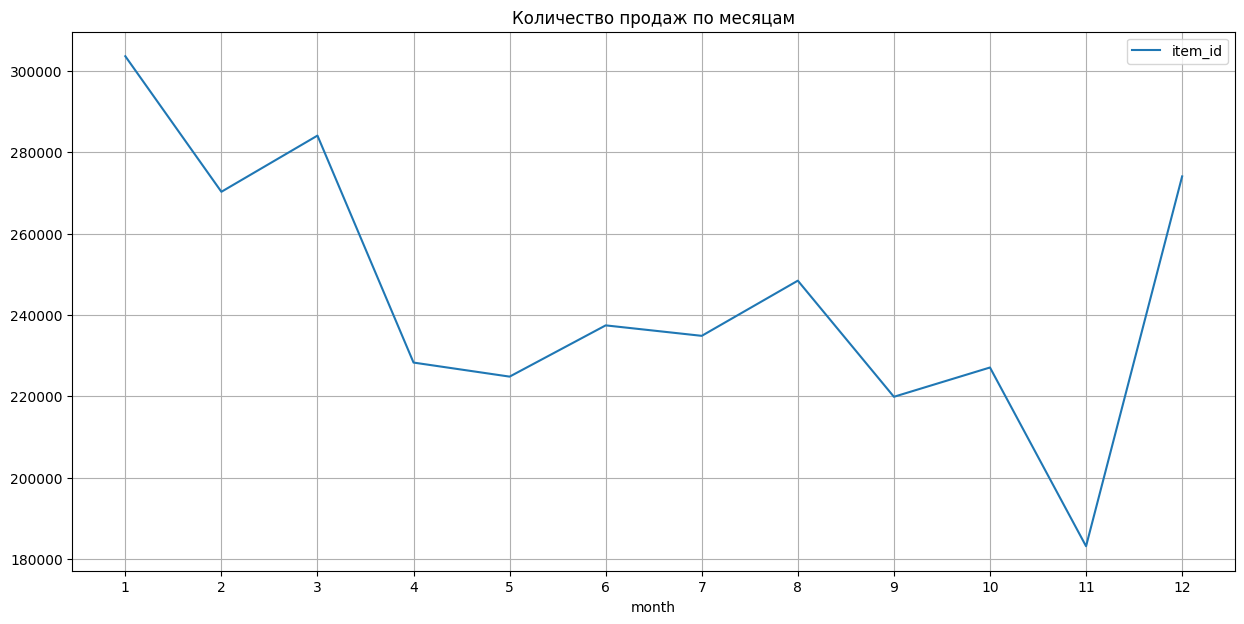

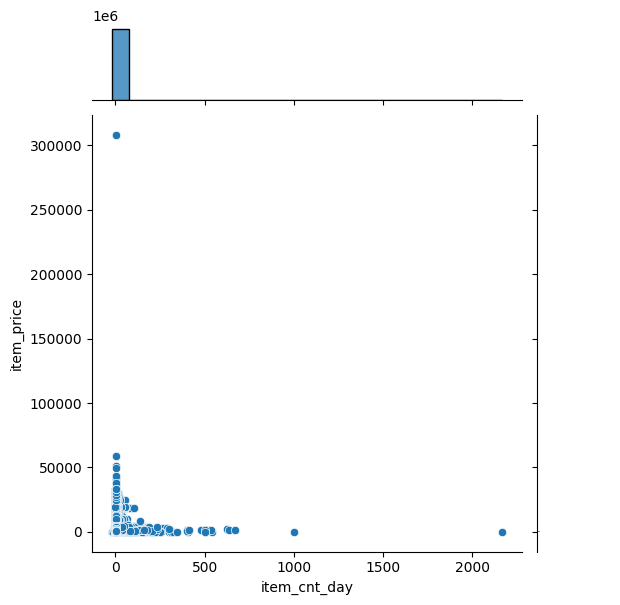

Decision Tree Classifier:
Accuracy: 0.925903780150919
Precision: 0.08860274629198328
Recall: 0.041548788399464555
F1 Score: 0.04699500557020434
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     77425
         1.0       0.34      0.06      0.10      4268
         2.0       0.19      0.03      0.05      1002
         3.0       0.15      0.03      0.05       353
         4.0       0.11      0.02      0.04       201
         5.0       0.03      0.01      0.02        97
         6.0       0.14      0.03      0.05        61
         7.0       0.00      0.00      0.00        51
         8.0       0.50      0.03      0.06        31
         9.0       0.00      0.00      0.00        32
        10.0       0.00      0.00      0.00        18
        11.0       0.33      0.07      0.12        14
        12.0       0.00      0.00      0.00        14
        13.0       0.00      0.00      0.00        10
        14.0       0.00      0.00      0.00  

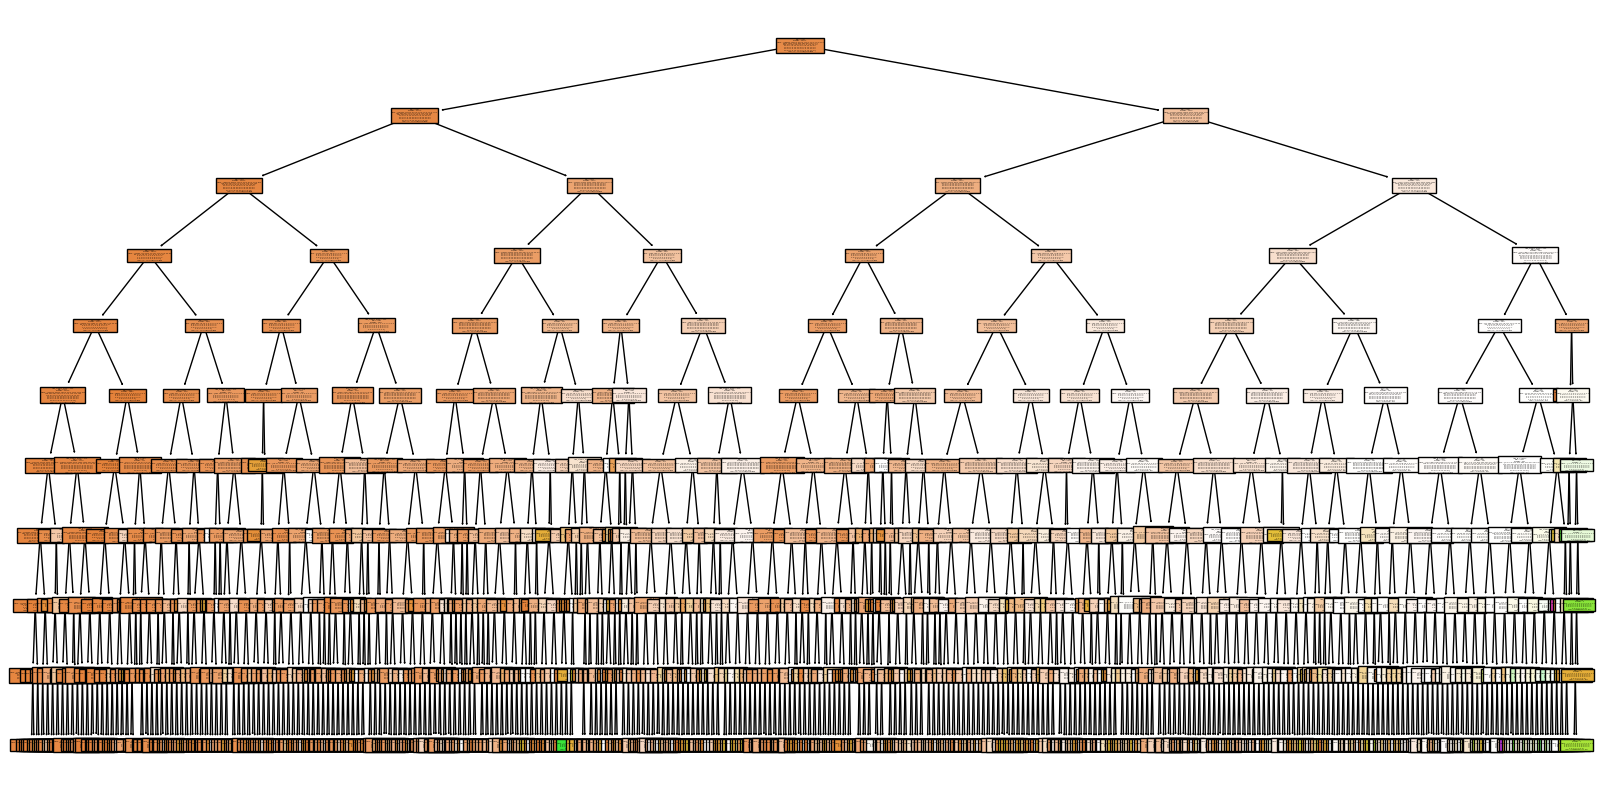

Random Forest Classifier:
Accuracy: 0.9262864591430382
Precision: 0.12396569684822542
Recall: 0.04640156260361915
F1 Score: 0.04923911753602769
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     77425
         1.0       0.27      0.01      0.02      4268
         2.0       0.17      0.00      0.01      1002
         3.0       0.10      0.01      0.02       353
         4.0       0.17      0.01      0.03       201
         5.0       1.00      0.01      0.02        97
         6.0       0.00      0.00      0.00        61
         7.0       0.00      0.00      0.00        51
         8.0       0.00      0.00      0.00        31
         9.0       0.00      0.00      0.00        32
        10.0       0.00      0.00      0.00        18
        11.0       0.00      0.00      0.00        14
        12.0       0.00      0.00      0.00        14
        13.0       0.00      0.00      0.00        10
        14.0       1.00      0.10      0.18  

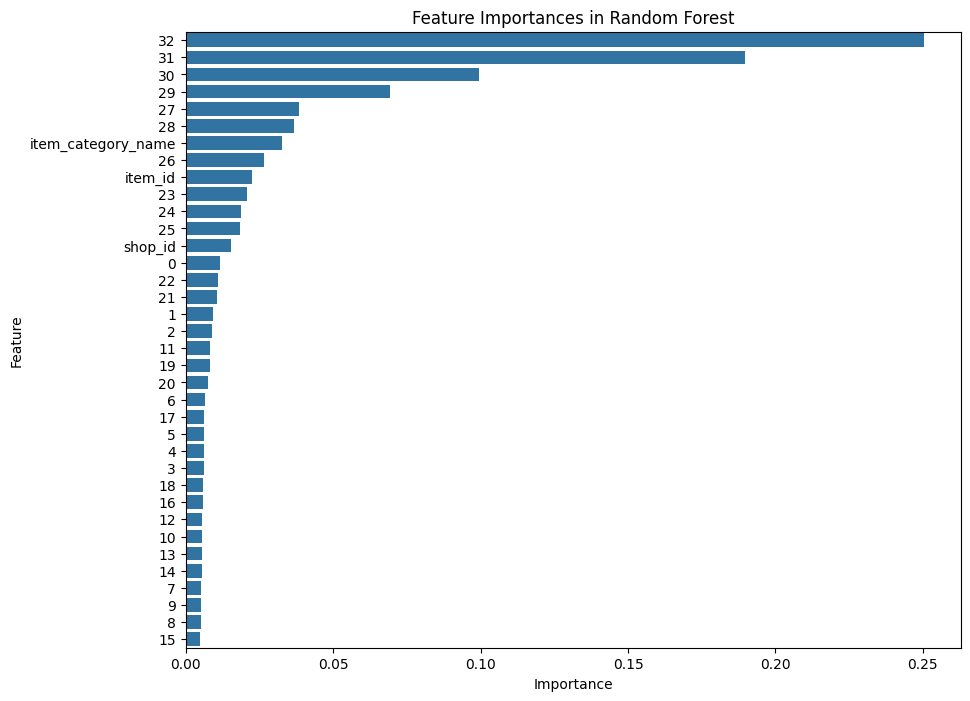

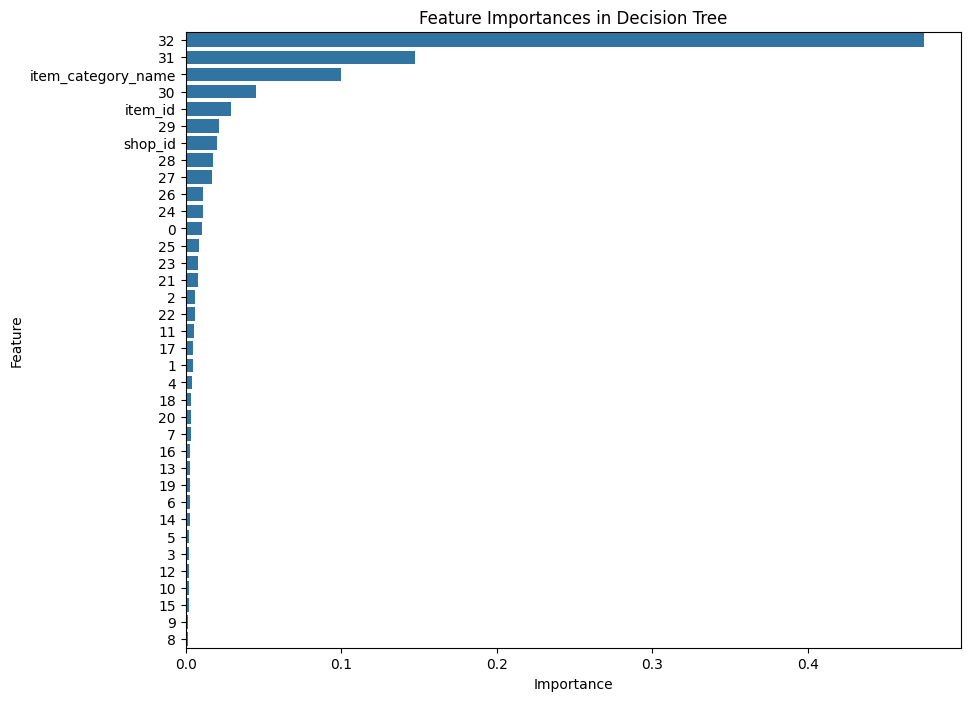

RMSE: 0.44157182709546133


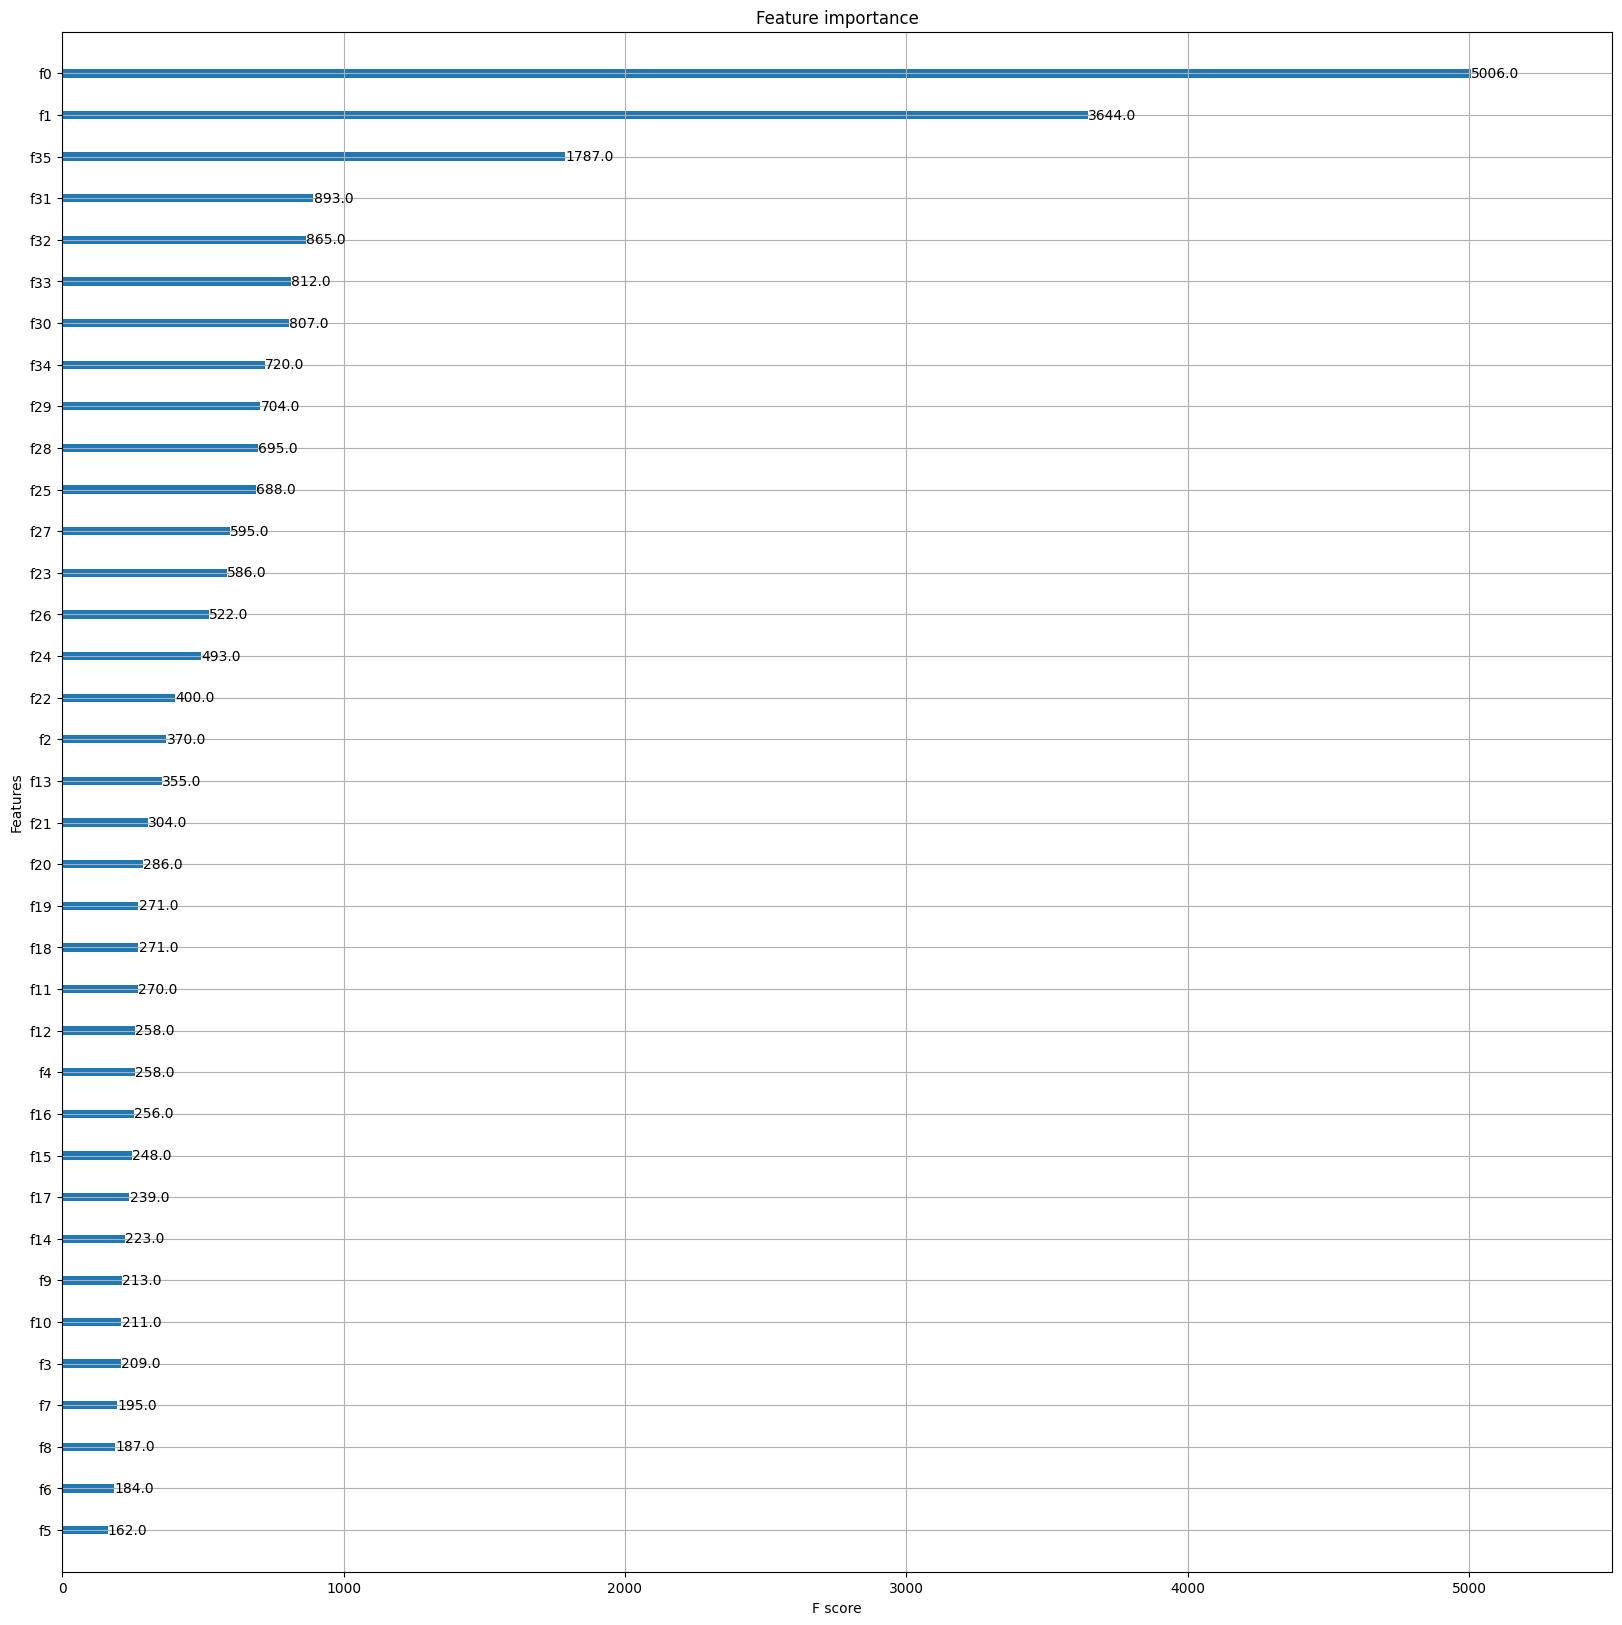

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, mean_squared_error
import xgboost as xgb
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

# Загрузка данных
item_categories = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv')
sales_train = pd.read_csv('sales_train.csv')
sample = pd.read_csv('sample_submission.csv')
shops = pd.read_csv('shops.csv')
test = pd.read_csv('test.csv')

# Объединение данных
items_df = pd.merge(items, item_categories, how='left', on='item_category_id')
train_df = pd.merge(sales_train, items_df, how='left', on='item_id')
train_df = pd.merge(train_df, shops, how='left', on='shop_id')

# Создание новых признаков
train_df['date'] = pd.to_datetime(train_df['date'], format='%d.%m.%Y')
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df.drop('date', axis=1, inplace=True)

# Визуализация данных
fig, ax = plt.subplots(figsize=(15, 7))
plt.xticks([i for i in range(1, 13)])
train_df.groupby(train_df['month']).count()['item_id'].plot(ax=ax)
plt.grid(True)
plt.title("Количество продаж по месяцам")
plt.legend()
plt.show()

sns.jointplot(x="item_cnt_day", y="item_price", data=train_df)
plt.show()

# Предварительная обработка данных
train_df.drop_duplicates(inplace=True)
train_df.drop(train_df[train_df.item_price > 3 * train_df.item_price.std()].index, inplace=True)
train_df.drop(train_df[train_df.item_cnt_day > 3 * train_df.item_cnt_day.std()].index, inplace=True)
train_df.drop(train_df[train_df.item_price < 0].index, inplace=True)
train_df.drop(train_df[train_df.item_cnt_day < 0].index, inplace=True)
train_df['revenue'] = train_df['item_price'] * train_df['item_cnt_day']

df = train_df.pivot_table(index=['shop_id', 'item_id'], columns='date_block_num', values='item_cnt_day', aggfunc='sum').fillna(0.0)
train_df = df.reset_index()
train_df["shop_id"] = train_df["shop_id"].astype("str")
train_df["item_id"] = train_df["item_id"].astype("str")

item_cat_df = items.merge(item_categories[['item_category_id', 'item_category_name']], on="item_category_id")[['item_id', 'item_category_name']]
item_cat_df['item_id'] = item_cat_df['item_id'].astype('str')
train_df = train_df.merge(item_cat_df, on="item_id")
train_df.dropna(axis=1, inplace=True)

le = LabelEncoder()
train_df['item_category_name'] = le.fit_transform(train_df['item_category_name'])
train_df.columns = train_df.columns.astype(str)  # Преобразование имен колонок в строки

# Разделение данных на тренировочные и тестовые
X = train_df.drop(columns=['33'])
y = train_df['33']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели дерева решений
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

# Оценка модели дерева решений
print("Decision Tree Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt, average='macro'))
print("Recall:", recall_score(y_test, y_pred_dt, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred_dt, average='macro'))
print(classification_report(y_test, y_pred_dt))

# Визуализация дерева решений
plt.figure(figsize=(20, 10))
plot_tree(dt_model, filled=True, feature_names=X.columns, class_names=le.classes_)
plt.show()

# Обучение модели случайного леса
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Оценка модели случайного леса
print("Random Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average='macro'))
print("Recall:", recall_score(y_test, y_pred_rf, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred_rf, average='macro'))
print(classification_report(y_test, y_pred_rf))

# Важность признаков для модели случайного леса
feature_importances_rf = rf_model.feature_importances_
features_rf = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_rf})
features_rf = features_rf.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=features_rf)
plt.title('Feature Importances in Random Forest')
plt.show()

# Важность признаков для модели дерева решений
feature_importances_dt = dt_model.feature_importances_
features_dt = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_dt})
features_dt = features_dt.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=features_dt)
plt.title('Feature Importances in Decision Tree')
plt.show()

# Настройка модели XGBoost
param = {
    'max_depth': 15,
    'subsample': 1,
    'min_child_weight': 1,
    'eta': 0.34,
    'seed': 1,
    'verbosity': 1,
    'eval_metric': 'rmse'
}

xgbtrain = xgb.DMatrix(X.values, y.values)
model = xgb.train(param, xgbtrain)
preds = model.predict(xgb.DMatrix(X.values))
RMSE = np.sqrt(mean_squared_error(preds, y.values))

print("RMSE:", RMSE)
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_importance(model, ax=ax)
plt.show()

# Подготовка тестовых данных и прогнозирование
test['shop_id'] = test['shop_id'].astype('str')
test['item_id'] = test['item_id'].astype('str')
test = test.merge(train_df, how="left", on=["shop_id", "item_id"]).fillna(0.0)
test.columns = test.columns.astype(str)  # Преобразование имен колонок в строки
predictions = model.predict(xgb.DMatrix(test.iloc[:, 2:].values))
predictions = list(map(lambda x: min(20, max(x, 0)), list(predictions)))

submission = pd.DataFrame({'ID': test['ID'], 'item_cnt_month': predictions})
submission.to_csv('submission.csv', index=False)
